## **1- Libraries imports**

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **2- Loading and reading the Dataset**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [ ]:
df = pd.read_csv('train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
df.loc[0, 'comment_text']

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

# 3- Data preprocessing and cleaning

# 3-1- Statistical overview

In [ ]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


# **3-2- Handle missing values**

In [ ]:
df.isnull().sum()

,0
id,0
comment_text,0
toxic,0
severe_toxic,0
obscene,0
threat,0
insult,0
identity_hate,0


there are no messing values in this dataset

In [ ]:
df.duplicated().sum()

np.int64(0)

# **3-3-Text Preprocessing**

In [ ]:
def preprocess_text(text):
    text = str(text).lower()

    # Replace IP addresses
    text = re.sub(r'\d{1,3}(\.\d{1,3}){3}', 'ipaddress', text)

    # Replace URLs
    text = re.sub(r'http[s]?://\S+', 'httpaddr', text)

    # Replace user mentions
    text = re.sub(r'@[\w\-]+', 'usermention', text)

    # Replace newlines and tabs
    text = text.replace('\n', ' ').replace('\t', ' ')

    # Expand common contractions
    contractions = {
        "can't": "cannot",
        "don't": "do not",
        "didn't": "did not",
        "aren't": "are not"
    }
    for c, e in contractions.items():
        text = text.replace(c, e)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text
df['clean_text'] = df['comment_text'].apply(preprocess_text)


# **4-Exploratory Data Analysis**

In [ ]:
print(df.iloc[:, 2:].dtypes)


toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
clean_text       object
dtype: object


In [ ]:
x = df.select_dtypes(include=[np.number]).sum()
x

,0
toxic,15294
severe_toxic,1595
obscene,8449
threat,478
insult,7877
identity_hate,1405


In [ ]:
rowsums = df.select_dtypes(include=[np.number]).sum(axis=1)
rowsums


,0
0,0
1,0
2,0
3,0
4,0
...,...
159566,0
159567,0
159568,0
159569,0


In [ ]:
df = df.drop(columns=['id'], axis=1)
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_text
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,d'aww! he matches this background colour i'm s...
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"hey man, i'm really not trying to edit war. it..."
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,""" more i cannot make any real suggestions on i..."
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,"you, sir, are my hero. any chance you remember..."


# 4-1-Label Distribution

In [ ]:
labels = [
    'toxic',
    'severe_toxic',
    'obscene',
    'threat',
    'insult',
    'identity_hate'
]

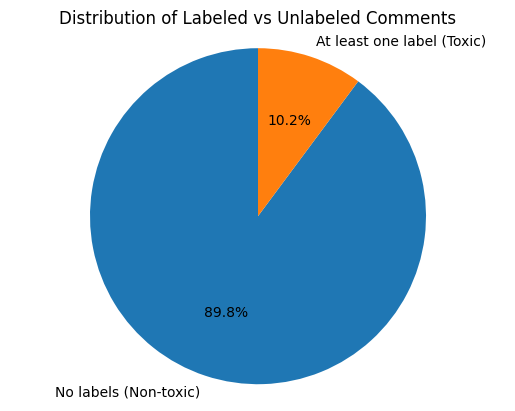

In [ ]:
import matplotlib.pyplot as plt

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Number of labels per comment
row_sums = df[labels].sum(axis=1)

# Count comments
no_label_count = (row_sums == 0).sum()      # non-toxic
labeled_count = (row_sums > 0).sum()        # toxic

sizes = [no_label_count, labeled_count]
names = ['No labels (Non-toxic)', 'At least one label (Toxic)']

plt.figure()
plt.pie(sizes, labels=names, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Labeled vs Unlabeled Comments')
plt.axis('equal')
plt.show()


Total number of comments: 159571
Total number of comments without labels: 143346
Total labels: 35098


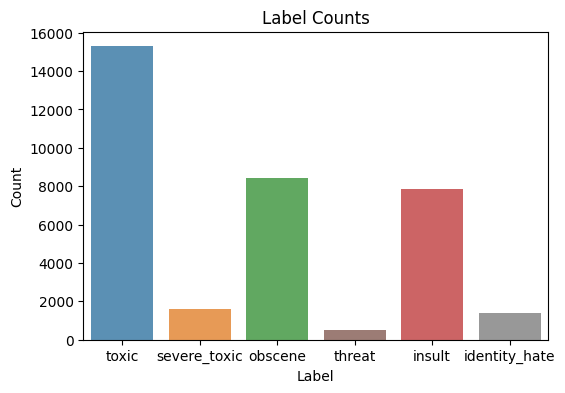

In [ ]:
no_label_count = 0

for i, count in rowsums.items():
    if count==0:
        no_label_count += 1

print('Total number of comments:', len(df))
print('Total number of comments without labels:', no_label_count)
print('Total labels:', x.sum())
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:brown', 'tab:red', 'tab:grey'])
plt.title('Label Counts')
plt.ylabel('Count')
plt.xlabel('Label')

plt.show()

Positive examples per label:
toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


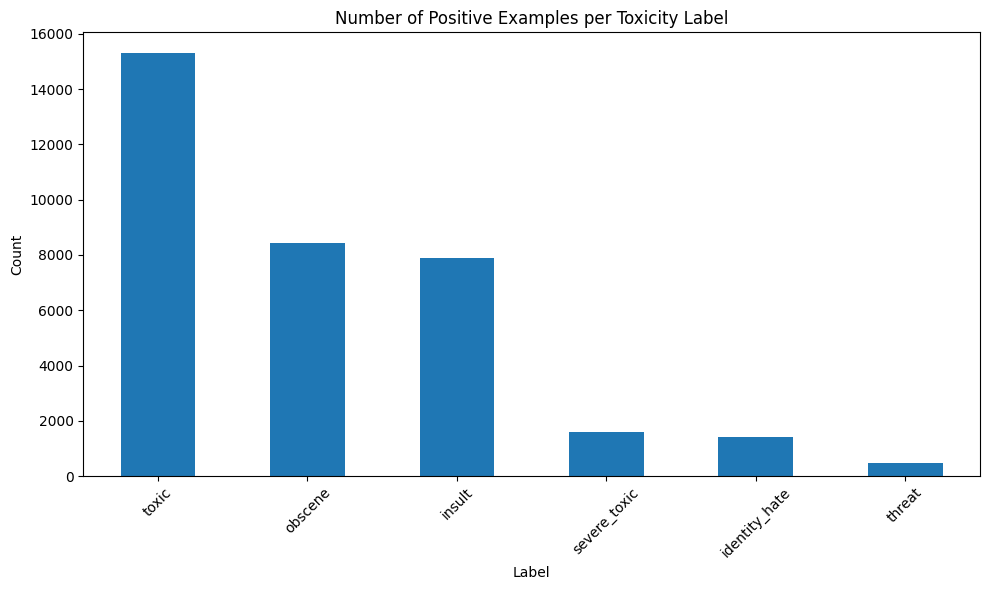

In [ ]:
print("Positive examples per label:")
print(df[labels].sum().sort_values(ascending=False))

df[labels].sum().sort_values(ascending=False).plot(
    kind='bar', figsize=(10, 6)
)
plt.title('Number of Positive Examples per Toxicity Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 4-2- Comment Length Analysis

count    159571.000000
mean        388.114538
std         582.931299
min           6.000000
25%          93.000000
50%         202.000000
75%         429.000000
max        5072.000000
Name: length, dtype: float64
any_toxic
0    398.240342
1    298.654237
Name: length, dtype: float64


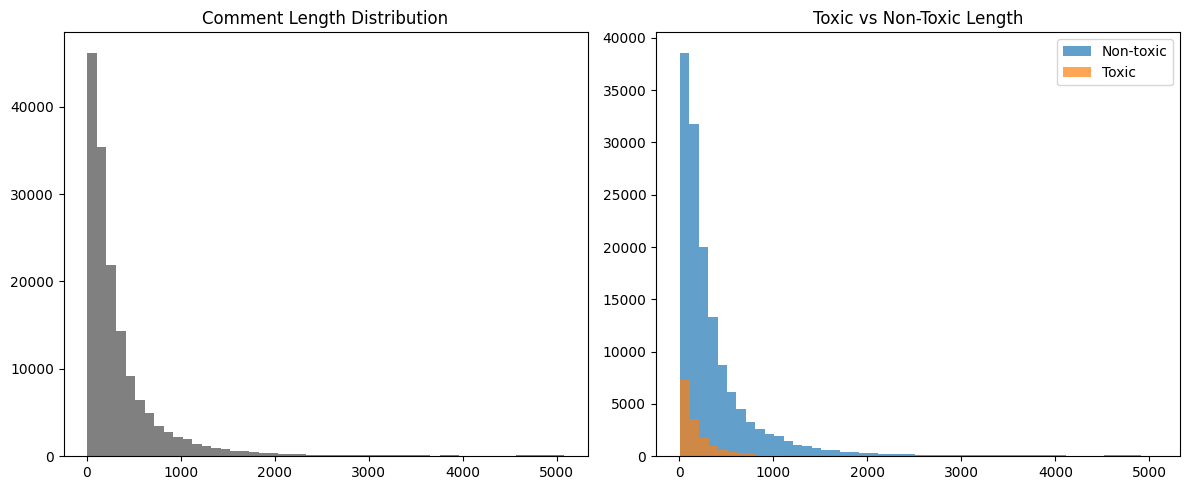

In [ ]:
df['length'] = df['clean_text'].str.len()
df['any_toxic'] = df[labels].max(axis=1)

print(df['length'].describe())
print(df.groupby('any_toxic')['length'].mean())
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['length'], bins=50, color='gray')
plt.title('Comment Length Distribution')

plt.subplot(1, 2, 2)
plt.hist(df[df['any_toxic'] == 0]['length'], bins=50, label='Non-toxic', alpha=0.7)
plt.hist(df[df['any_toxic'] == 1]['length'], bins=50, label='Toxic', alpha=0.7)
plt.legend()
plt.title('Toxic vs Non-Toxic Length')

plt.tight_layout()
plt.show()


# 4-3-Label Correlation and Overlap

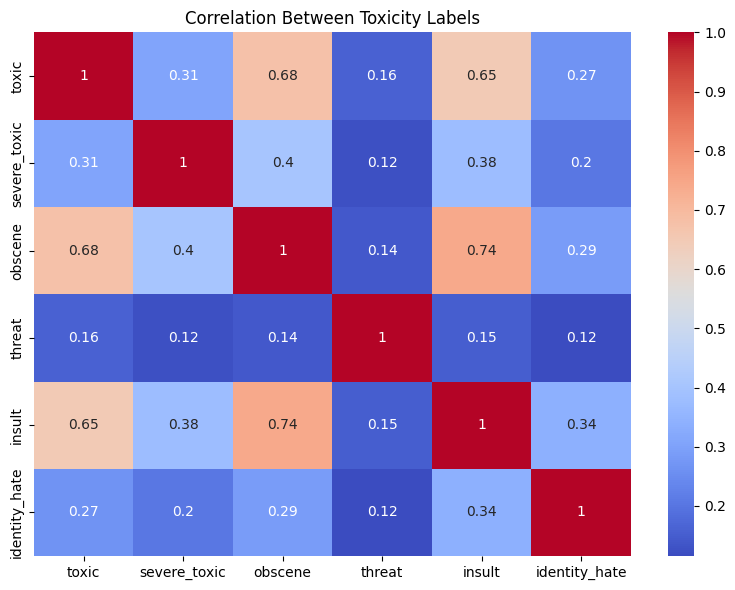

0    143346
1      6360
2      3480
3      4209
4      1760
5       385
6        31
Name: count, dtype: int64


In [ ]:
correlation_matrix = df[labels].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Between Toxicity Labels')
plt.tight_layout()
plt.show()
overlap_counts = df[labels].sum(axis=1).value_counts().sort_index()
print(overlap_counts)



# 4-4-Word Cloud Visualization

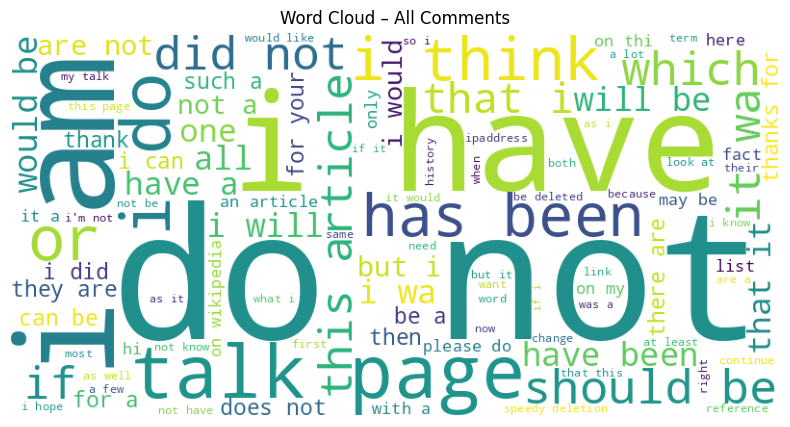

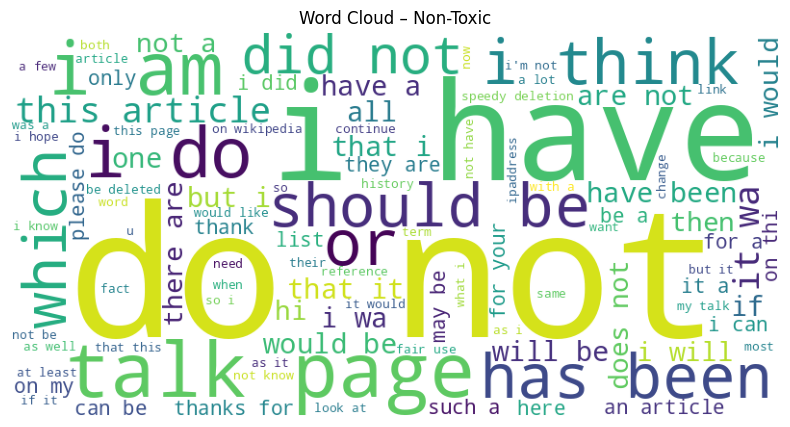

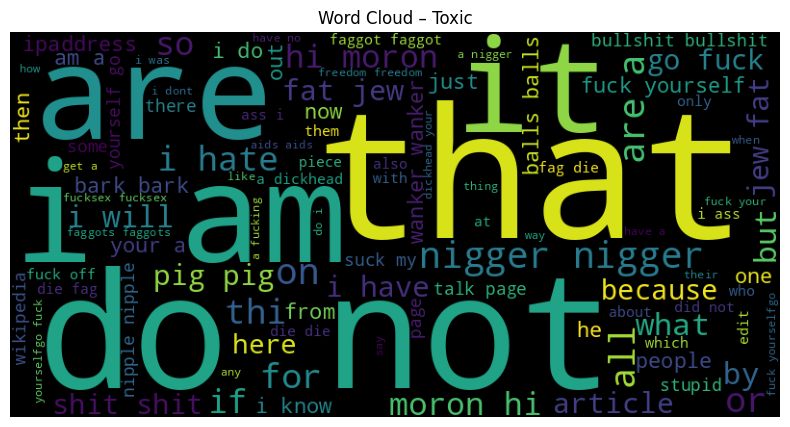

In [ ]:
def generate_wordcloud(text_series, title, background_color='white'):
    text = ' '.join(text_series)
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color=background_color,
        max_words=100,
        stopwords={'the', 'and', 'to', 'of', 'in', 'is', 'you'}
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title)
    plt.show()
generate_wordcloud(df['clean_text'], 'Word Cloud – All Comments')
generate_wordcloud(df[df['any_toxic'] == 0]['clean_text'], 'Word Cloud – Non-Toxic')
generate_wordcloud(df[df['any_toxic'] == 1]['clean_text'], 'Word Cloud – Toxic', background_color='black')


# **5- Logistic Regression-Based Multi-Label Classification**

In [ ]:
df = pd.read_csv('train.csv')

labels = [
    'toxic',
    'severe_toxic',
    'obscene',
    'threat',
    'insult',
    'identity_hate'
]

df['clean_text'] = df['comment_text'].astype(str).str.strip().str.lower()

# 5-1-Train validation split

In [ ]:
print(df.columns)


Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'clean_text'],
      dtype='object')


In [ ]:
df['any_toxic'] = df[labels].max(axis=1)
train_val_df, test_df = train_test_split(
    df,
    test_size=0.1,
    random_state=42,
    stratify=df['any_toxic']
)

train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.2,
    random_state=42,
    stratify=train_val_df['any_toxic']
)

X_train, y_train = train_df['clean_text'], train_df[labels]
X_val, y_val     = val_df['clean_text'], val_df[labels]
X_test, y_test   = test_df['clean_text'], test_df[labels]


# 5-2- Feature Extraction Using TF-IDF

In [ ]:
tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),
    analyzer='word',
    stop_words='english',
    sublinear_tf=True
)

# Fit on train, transform all splits
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf   = tfidf.transform(X_val)
X_test_tfidf  = tfidf.transform(X_test)

print(f"Vocabulary size: {len(tfidf.vocabulary_)}")
print(f"Train shape: {X_train_tfidf.shape}")
print(f"Val shape: {X_val_tfidf.shape}")
print(f"Test shape: {X_test_tfidf.shape}")


Vocabulary size: 50000
Train shape: (114890, 50000)
Val shape: (28723, 50000)
Test shape: (15958, 50000)


# 5-3- Multi-Label Classification Model with Oversampling

In [ ]:
models = {}
y_pred_proba = np.zeros((X_val_tfidf.shape[0], len(labels)))

for i, label in enumerate(labels):
    print(f"Training model for: {label}")

    # Oversample minority class
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(
        X_train_tfidf, y_train[label]
    )
    print(f"{label}: X_resampled shape {X_resampled.shape}, y_resampled shape {y_resampled.shape}")



    # Logistic Regression classifier
    clf = LogisticRegression(
        solver='saga',
        class_weight='balanced',
        C=5,
        max_iter=1000
    )

    clf.fit(X_resampled, y_resampled)
    models[label] = clf

    # Validation probabilities
    y_pred_proba[:, i] = clf.predict_proba(X_val_tfidf)[:, 1]


Training model for: toxic
toxic: X_resampled shape (207696, 50000), y_resampled shape (207696,)
Training model for: severe_toxic
severe_toxic: X_resampled shape (227434, 50000), y_resampled shape (227434,)
Training model for: obscene
obscene: X_resampled shape (217534, 50000), y_resampled shape (217534,)
Training model for: threat
threat: X_resampled shape (229084, 50000), y_resampled shape (229084,)
Training model for: insult
insult: X_resampled shape (218414, 50000), y_resampled shape (218414,)
Training model for: identity_hate
identity_hate: X_resampled shape (227728, 50000), y_resampled shape (227728,)


# 5-4- Per Label Threshold Optimization

In [ ]:

best_thresholds = []

for i, label in enumerate(labels):
    best_f1 = 0
    best_t = 0.5

    for t in np.arange(0.1, 0.95, 0.05):
        preds = (y_pred_proba[:, i] >= t).astype(int)
        f1 = f1_score(y_val[label], preds)

        if f1 > best_f1:
            best_f1 = f1
            best_t = t

    best_thresholds.append(best_t)
    print(f"{label}: Best threshold = {best_t:.2f}, F1 = {best_f1:.4f}")


toxic: Best threshold = 0.70, F1 = 0.7646
severe_toxic: Best threshold = 0.90, F1 = 0.4696
obscene: Best threshold = 0.70, F1 = 0.8092
threat: Best threshold = 0.65, F1 = 0.4569
insult: Best threshold = 0.65, F1 = 0.6955
identity_hate: Best threshold = 0.75, F1 = 0.4930


In [ ]:
y_pred_tuned = np.zeros_like(y_pred_proba, dtype=int)

for i, t in enumerate(best_thresholds):
    y_pred_tuned[:, i] = (y_pred_proba[:, i] >= t).astype(int)


# 6- Model Evaluation

In [ ]:
auc_scores = [
    roc_auc_score(y_val[labels[i]], y_pred_proba[:, i])
    for i in range(len(labels))
]

print(f"\nMean ROC-AUC Score: {np.mean(auc_scores):.4f}")



Mean ROC-AUC Score: 0.9718


In [ ]:
from sklearn.metrics import roc_auc_score

for i, label in enumerate(labels):
    auc = roc_auc_score(y_val[label], y_pred_proba[:, i])
    print(f"{label:15s} ROC-AUC = {auc:.4f}")


toxic           ROC-AUC = 0.9634
severe_toxic    ROC-AUC = 0.9759
obscene         ROC-AUC = 0.9814
threat          ROC-AUC = 0.9768
insult          ROC-AUC = 0.9712
identity_hate   ROC-AUC = 0.9623


In [ ]:
print("\nClassification Report (Tuned Thresholds):")
print(
    classification_report(
        y_val,
        y_pred_tuned,
        target_names=labels,
        zero_division=0
    )
)



Classification Report (Tuned Thresholds):
               precision    recall  f1-score   support

        toxic       0.79      0.74      0.76      2727
 severe_toxic       0.44      0.50      0.47       279
      obscene       0.82      0.80      0.81      1500
       threat       0.41      0.51      0.46        88
       insult       0.67      0.72      0.70      1416
identity_hate       0.43      0.57      0.49       247

    micro avg       0.73      0.73      0.73      6257
    macro avg       0.60      0.64      0.61      6257
 weighted avg       0.73      0.73      0.73      6257
  samples avg       0.06      0.07      0.06      6257



In [ ]:
conf_matrices = {}

for i, label in enumerate(labels):
    y_true = y_val[label].values
    y_pred = y_pred_tuned[:, i]

    # Confusion matrix format:
    # [[True Negatives, False Positives],
    #  [False Negatives, True Positives]]
    cm = confusion_matrix(y_true, y_pred)
    conf_matrices[label] = cm


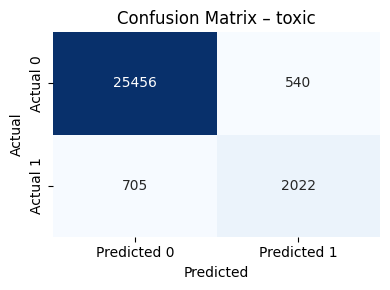

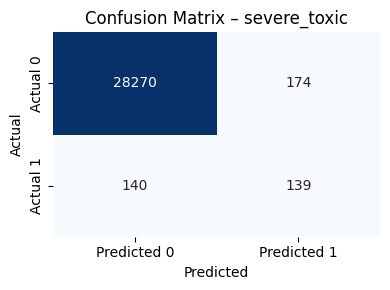

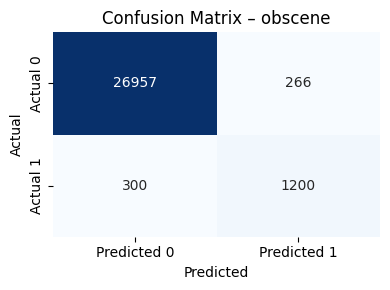

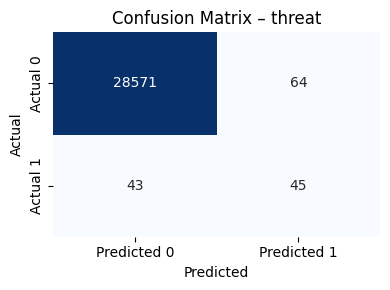

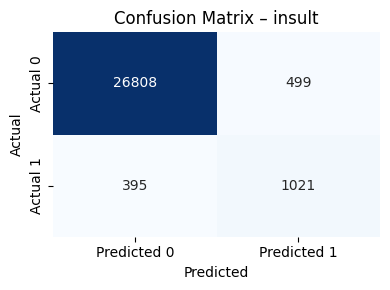

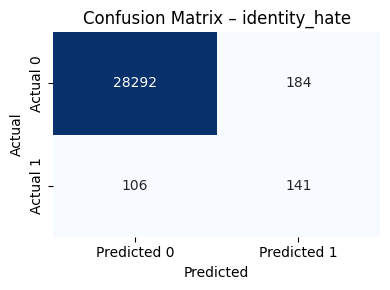

In [ ]:
for label, cm in conf_matrices.items():
    plt.figure(figsize=(4, 3))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        cbar=False,
        xticklabels=['Predicted 0', 'Predicted 1'],
        yticklabels=['Actual 0', 'Actual 1']
    )
    plt.title(f'Confusion Matrix – {label}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()


In [ ]:
# Initialize array to store predicted probabilities
y_test_proba = np.zeros((X_test_tfidf.shape[0], len(labels)))

# Predict probabilities for each label
for i, label in enumerate(labels):
    y_test_proba[:, i] = models[label].predict_proba(X_test_tfidf)[:, 1]

# Convert probabilities to binary using tuned thresholds
y_test_pred = np.zeros_like(y_test_proba, dtype=int)
for i, t in enumerate(best_thresholds):
    y_test_pred[:, i] = (y_test_proba[:, i] >= t).astype(int)

# Evaluate per-label ROC-AUC
print("Test set ROC-AUC per label:")
for i, label in enumerate(labels):
    auc = roc_auc_score(y_test[label], y_test_proba[:, i])
    print(f"{label:15s} | ROC-AUC = {auc:.4f}")

# Weighted F1, Precision, Recall
weighted_f1 = f1_score(y_test, y_test_pred, average='weighted')
weighted_precision = precision_score(y_test, y_test_pred, average='weighted')
weighted_recall = recall_score(y_test, y_test_pred, average='weighted')

print("\nTest set Weighted metrics (tuned thresholds):")
print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall:    {weighted_recall:.4f}")
print(f"Weighted F1:        {weighted_f1:.4f}")


Test set ROC-AUC per label:
toxic           | ROC-AUC = 0.9655
severe_toxic    | ROC-AUC = 0.9781
obscene         | ROC-AUC = 0.9795
threat          | ROC-AUC = 0.9557
insult          | ROC-AUC = 0.9712
identity_hate   | ROC-AUC = 0.9584

Test set Weighted metrics (tuned thresholds):
Weighted Precision: 0.7255
Weighted Recall:    0.7374
Weighted F1:        0.7292


# 7- test a new comment

In [ ]:
def classify_new_comment(
    comment,
    tfidf,
    models,
    labels,
    thresholds
):
    clean_comment = str(comment).strip().lower()
    X = tfidf.transform([clean_comment])
    results = {}
    for i, label in enumerate(labels):
        prob = models[label].predict_proba(X)[0, 1]
        pred = int(prob >= thresholds[i])

        results[label] = {
            "probability": round(prob, 4),
            "prediction": pred
        }

    return results


In [ ]:
test_comment = "You are very annoying and rude"

output = classify_new_comment(
    comment=test_comment,
    tfidf=tfidf,
    models=models,
    labels=labels,
    thresholds=best_thresholds
)

for label, result in output.items():
    print(f"{label:15s} → Prob: {result['probability']:.3f} | Pred: {result['prediction']}")


toxic           → Prob: 0.970 | Pred: 1
severe_toxic    → Prob: 0.010 | Pred: 0
obscene         → Prob: 0.070 | Pred: 0
threat          → Prob: 0.001 | Pred: 0
insult          → Prob: 0.026 | Pred: 0
identity_hate   → Prob: 0.036 | Pred: 0


In [ ]:
test_comment = "kill yourself"

output = classify_new_comment(
    comment=test_comment,
    tfidf=tfidf,
    models=models,
    labels=labels,
    thresholds=best_thresholds
)

for label, result in output.items():
    print(f"{label:15s} → Prob: {result['probability']:.3f} | Pred: {result['prediction']}")


toxic           → Prob: 0.999 | Pred: 1
severe_toxic    → Prob: 0.308 | Pred: 0
obscene         → Prob: 0.411 | Pred: 0
threat          → Prob: 1.000 | Pred: 1
insult          → Prob: 0.493 | Pred: 0
identity_hate   → Prob: 0.147 | Pred: 0


In [ ]:
test_comment = "very informative"

output = classify_new_comment(
    comment=test_comment,
    tfidf=tfidf,
    models=models,
    labels=labels,
    thresholds=best_thresholds
)

for label, result in output.items():
    print(f"{label:15s} → Prob: {result['probability']:.3f} | Pred: {result['prediction']}")


toxic           → Prob: 0.021 | Pred: 0
severe_toxic    → Prob: 0.011 | Pred: 0
obscene         → Prob: 0.015 | Pred: 0
threat          → Prob: 0.001 | Pred: 0
insult          → Prob: 0.008 | Pred: 0
identity_hate   → Prob: 0.038 | Pred: 0
